# Práctica 3: Comparación de Clasificadores con Reducción de Dimensionalidad

**Fundamentos del Aprendizaje Automático - Curso 2025-2026**

Este notebook implementa:
1. **Reducción de dimensionalidad**: PCA (≥60% varianza) y Autoencoder neuronal (mitad de features)
2. **Clasificadores**: k-NN y Perceptrón Multicapa (MLP)
3. **Evaluación**: Validación cruzada 5-fold estratificada
4. **Análisis estadístico**: Test de Wilcoxon para comparar métodos

---

## 1. Importación de Librerías

In [20]:
# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import pandas as pd
import numpy as np
import os
import warnings
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Estadística
from scipy.stats import wilcoxon

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning if 'ConvergenceWarning' in dir() else UserWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 80)
print("✓ Librerías importadas correctamente")
print("=" * 80)

✓ Librerías importadas correctamente


## 2. Configuración de Rutas y Parámetros

In [21]:
# ============================================================================
# 2. CONFIGURACIÓN DE RUTAS Y PARÁMETROS
# ============================================================================

# Rutas base
BASE_PATH = Path('./data')
ORIGINAL_PATH = BASE_PATH / 'original'
PCA_PATH = BASE_PATH / 'pca'
AUTOENCODER_PATH = BASE_PATH / 'autoencoder'

# Crear directorios si no existen
PCA_PATH.mkdir(parents=True, exist_ok=True)
AUTOENCODER_PATH.mkdir(parents=True, exist_ok=True)

# Parámetros de validación cruzada
N_SPLITS = 5
P_VALOR_THRESHOLD = 0.05

# Parámetros de PCA
PCA_MIN_VARIANCE = 0.60  # Al menos 60% de varianza acumulada

# Parámetros del Autoencoder
AE_ACTIVATIONS = ['relu', 'tanh']
AE_MAX_ITERS = [500, 1000]
AE_HIDDEN_SIZES = [(64, 32), (128, 64)]

# Parámetros de k-NN
KNN_K_VALUES = [1, 3, 5, 7, 9, 11]

# Parámetros del MLP Classifier
MLP_HIDDEN_SIZES = [(50,), (100,), (50, 25), (100, 50)]
MLP_ACTIVATIONS = ['relu', 'tanh']
MLP_MAX_ITERS = [500, 1000]

print("=" * 80)
print("CONFIGURACIÓN")
print("=" * 80)
print(f"\n📁 Rutas:")
print(f"   Original:    {ORIGINAL_PATH}")
print(f"   PCA:         {PCA_PATH}")
print(f"   Autoencoder: {AUTOENCODER_PATH}")
print(f"\n📊 Validación Cruzada: {N_SPLITS}-fold estratificada")
print(f"📏 PCA: mínimo {PCA_MIN_VARIANCE*100:.0f}% de varianza acumulada")
print(f"🎯 p-valor threshold: {P_VALOR_THRESHOLD}")
print("=" * 80)

CONFIGURACIÓN

📁 Rutas:
   Original:    data/original
   PCA:         data/pca
   Autoencoder: data/autoencoder

📊 Validación Cruzada: 5-fold estratificada
📏 PCA: mínimo 60% de varianza acumulada
🎯 p-valor threshold: 0.05


## 3. Funciones Auxiliares para Carga y Procesamiento de Datos

In [22]:
# ============================================================================
# 3. FUNCIONES AUXILIARES
# ============================================================================

def detect_dataset_config(df, dataset_name):
    """
    Detecta automáticamente la configuración del dataset:
    - Columnas de features
    - Columna de clase
    - Columnas a excluir (nombres, IDs, fechas)
    """
    # Columnas comunes de clase (en orden de prioridad)
    class_cols = ['type', 'class', 'label', 'target', 'occupancy_class', 'category', 'quarter']
    # Columnas a excluir (identificadores, fechas)
    exclude_patterns = ['name', 'id', 'date', 'animal', 'code']
    
    # Detectar columna de clase
    class_col = None
    for col in class_cols:
        if col in df.columns.str.lower().tolist():
            idx = df.columns.str.lower().tolist().index(col)
            class_col = df.columns[idx]
            break
    
    if class_col is None:
        # Usar última columna como clase si no se detecta
        class_col = df.columns[-1]
        print(f"   ⚠️ Clase no detectada, usando última columna: '{class_col}'")
    
    # Detectar columnas a excluir
    exclude_cols = [class_col]
    for col in df.columns:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in exclude_patterns):
            exclude_cols.append(col)
        # Excluir columnas de tipo fecha
        if df[col].dtype == 'object':
            try:
                pd.to_datetime(df[col])
                exclude_cols.append(col)
            except:
                pass
    
    # Excluir columnas que no sean numéricas (excepto la clase)
    for col in df.columns:
        if col not in exclude_cols and df[col].dtype == 'object' and col != class_col:
            exclude_cols.append(col)
    
    exclude_cols = list(set(exclude_cols))
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Filtrar solo columnas numéricas
    numeric_feature_cols = []
    for col in feature_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_feature_cols.append(col)
    
    return {
        'class_col': class_col,
        'feature_cols': numeric_feature_cols,
        'exclude_cols': exclude_cols
    }


def load_dataset(file_path, dataset_name):
    """
    Carga un dataset original y retorna X (features) e y (etiquetas).
    """
    df = pd.read_csv(file_path)
    config = detect_dataset_config(df, dataset_name)
    
    X = df[config['feature_cols']].copy()
    y = df[config['class_col']].copy()
    
    # Codificar etiquetas si es necesario
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print(f"\n📊 Dataset: {dataset_name}")
    print(f"   Features: {len(config['feature_cols'])} columnas")
    print(f"   Clase: '{config['class_col']}' ({len(le.classes_)} clases)")
    print(f"   Muestras: {len(X)}")
    print(f"   Clases: {list(le.classes_)[:5]}..." if len(le.classes_) > 5 else f"   Clases: {list(le.classes_)}")
    
    return X, y_encoded, le, config


def get_dataset_name(file_path):
    """Extrae el nombre base del dataset desde la ruta del archivo."""
    return Path(file_path).stem.replace('_pca', '').replace('_autoencoder', '')


def discover_datasets():
    """
    Descubre automáticamente todos los datasets disponibles en las carpetas.
    Retorna un diccionario con la estructura de datasets.
    """
    datasets = {}
    
    # Buscar archivos originales
    for file_path in ORIGINAL_PATH.glob('*.csv'):
        name = file_path.stem
        datasets[name] = {
            'original': file_path,
            'pca': PCA_PATH / f'{name}_pca.csv',
            'autoencoder': AUTOENCODER_PATH / f'{name}_autoencoder.csv'
        }
    
    return datasets

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


## 4. Generación de Versiones PCA y Autoencoder

### T1: Reducción de Dimensionalidad
- **PCA**: Reducción con al menos 60% de varianza acumulada
- **Autoencoder**: Reducción a la mitad de características usando `MLPRegressor`

In [23]:
# ============================================================================
# 4.1 FUNCIÓN PARA APLICAR PCA
# ============================================================================

def apply_pca(X, dataset_name, min_variance=0.60):
    """
    Aplica PCA manteniendo al menos min_variance de varianza acumulada.
    """
    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Primero ajustamos PCA completo para ver varianza explicada
    pca_full = PCA(random_state=RANDOM_STATE)
    pca_full.fit(X_scaled)
    
    # Encontrar número mínimo de componentes para alcanzar varianza objetivo
    cumsum = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= min_variance) + 1
    
    # Asegurar al menos 2 componentes
    n_components = max(2, n_components)
    
    # Aplicar PCA con los componentes seleccionados
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)
    
    variance_explained = np.sum(pca.explained_variance_ratio_)
    
    print(f"\n🔷 PCA para '{dataset_name}':")
    print(f"   Features originales: {X.shape[1]}")
    print(f"   Componentes PCA: {n_components}")
    print(f"   Varianza explicada: {variance_explained*100:.2f}%")
    
    # Crear DataFrame con nombres de columnas
    cols = [f'PCA_{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(X_pca, columns=cols)
    
    return df_pca, pca, scaler


# ============================================================================
# 4.2 FUNCIÓN PARA APLICAR AUTOENCODER
# ============================================================================

def apply_autoencoder(X, dataset_name, target_dim=None):
    """
    Aplica un autoencoder neuronal para reducir dimensionalidad.
    El espacio latente (bottleneck) tiene la mitad de las features originales.
    """
    if target_dim is None:
        target_dim = max(2, X.shape[1] // 2)  # Mitad de features, mínimo 2
    
    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Arquitectura del autoencoder: encoder -> bottleneck -> decoder
    # Usamos MLPRegressor para reconstruir la entrada
    input_dim = X.shape[1]
    
    # Capas: input -> hidden -> bottleneck -> hidden -> output
    # Para extraer el bottleneck, entrenamos el autoencoder completo
    # y luego usamos solo la primera mitad (encoder)
    
    # Arquitectura simétrica
    encoder_dim = max(target_dim * 2, input_dim // 2)
    hidden_layers = (encoder_dim, target_dim, encoder_dim)
    
    print(f"\n🔶 Autoencoder para '{dataset_name}':")
    print(f"   Features originales: {input_dim}")
    print(f"   Dimensión latente objetivo: {target_dim}")
    print(f"   Arquitectura: {input_dim} → {encoder_dim} → {target_dim} → {encoder_dim} → {input_dim}")
    
    # Entrenar autoencoder
    autoencoder = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        verbose=False
    )
    
    autoencoder.fit(X_scaled, X_scaled)
    
    # Extraer representación del bottleneck
    # Propagamos hacia adelante hasta la capa del bottleneck
    X_encoded = X_scaled.copy()
    
    # Aplicar capas del encoder (solo hasta el bottleneck)
    n_encoder_layers = len(hidden_layers) // 2 + 1  # Hasta la capa central
    
    for i in range(n_encoder_layers):
        W = autoencoder.coefs_[i]
        b = autoencoder.intercepts_[i]
        X_encoded = np.dot(X_encoded, W) + b
        # Aplicar activación ReLU excepto posiblemente en la última
        X_encoded = np.maximum(0, X_encoded)
    
    # Calcular error de reconstrucción
    X_reconstructed = autoencoder.predict(X_scaled)
    reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)
    
    print(f"   Error de reconstrucción (MSE): {reconstruction_error:.6f}")
    print(f"   Dimensión del encoding: {X_encoded.shape[1]}")
    
    # Crear DataFrame con nombres de columnas
    cols = [f'AE_{i+1}' for i in range(X_encoded.shape[1])]
    df_ae = pd.DataFrame(X_encoded, columns=cols)
    
    return df_ae, autoencoder, scaler

print("✓ Funciones de reducción de dimensionalidad definidas")

✓ Funciones de reducción de dimensionalidad definidas



In [24]:
# ============================================================================
# 4.3 GENERAR VERSIONES PCA Y AUTOENCODER PARA TODOS LOS DATASETS
# ============================================================================

print("=" * 80)
print("GENERACIÓN DE VERSIONES REDUCIDAS DE LOS DATASETS")
print("=" * 80)

# Descubrir datasets disponibles
datasets_info = discover_datasets()
print(f"\n📁 Datasets encontrados: {list(datasets_info.keys())}")

# Para cada dataset, generar PCA y Autoencoder si no existen
for name, paths in datasets_info.items():
    print(f"\n{'='*60}")
    print(f"Procesando: {name.upper()}")
    print(f"{'='*60}")
    
    # Cargar dataset original
    X, y, le, config = load_dataset(paths['original'], name)
    
    # Generar PCA si no existe
    if not paths['pca'].exists():
        df_pca, pca_model, pca_scaler = apply_pca(X, name, PCA_MIN_VARIANCE)
        df_pca.to_csv(paths['pca'], index=False)
        print(f"   ✅ Guardado: {paths['pca']}")
    else:
        print(f"\n🔷 PCA para '{name}': Ya existe, cargando...")
        df_pca = pd.read_csv(paths['pca'])
        print(f"   Componentes: {df_pca.shape[1]}")
    
    # Generar Autoencoder si no existe
    if not paths['autoencoder'].exists():
        df_ae, ae_model, ae_scaler = apply_autoencoder(X, name)
        df_ae.to_csv(paths['autoencoder'], index=False)
        print(f"   ✅ Guardado: {paths['autoencoder']}")
    else:
        print(f"\n🔶 Autoencoder para '{name}': Ya existe, cargando...")
        df_ae = pd.read_csv(paths['autoencoder'])
        print(f"   Dimensión: {df_ae.shape[1]}")

print("\n" + "=" * 80)
print("✅ Todas las versiones de los datasets están listas")
print("=" * 80)

GENERACIÓN DE VERSIONES REDUCIDAS DE LOS DATASETS

📁 Datasets encontrados: ['zoo', 'spotify', 'cinema']

Procesando: ZOO

📁 Datasets encontrados: ['zoo', 'spotify', 'cinema']

Procesando: ZOO

📊 Dataset: zoo
   Features: 16 columnas
   Clase: 'type' (7 clases)
   Muestras: 287
   Clases: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...

🔷 PCA para 'zoo': Ya existe, cargando...
   Componentes: 4

🔶 Autoencoder para 'zoo': Ya existe, cargando...

📊 Dataset: zoo
   Features: 16 columnas
   Clase: 'type' (7 clases)
   Muestras: 287
   Clases: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...

🔷 PCA para 'zoo': Ya existe, cargando...
   Componentes: 4

🔶 Autoencoder para 'zoo': Ya existe, cargando...
   Dimensión: 8

Procesando: SPOTIFY
   ⚠️ Clase no detectada, usando última columna: 'Popularity'

📊 Dataset: spotify
   Features: 10 columnas
   Clase: 'Popularity' (81 clases)
   Muestras: 1994
   Clases: [np.int64(11), np.int64(12), np.int64(13), np.in

## 5. Clasificadores: k-NN y MLP

### T3: Implementación de Clasificadores
- **k-NN**: Optimización del parámetro `k` mediante validación cruzada
- **MLP**: Optimización de `hidden_layer_sizes`, `activation` y `max_iter`

Estrategia de evaluación:
1. Validación cruzada 5-fold estratificada
2. En cada fold: Train+Val (80%) para optimización, Test (20%) para evaluación
3. Se reporta F1-macro promedio ± desviación estándar

In [25]:
# ============================================================================
# 5.1 FUNCIÓN DE EVALUACIÓN CON VALIDACIÓN CRUZADA
# ============================================================================

def evaluate_classifier_cv(classifier_class, X, y, param_grid, classifier_name, n_splits=5):
    """
    Evalúa un clasificador usando validación cruzada anidada.
    
    - Outer loop: 5-fold para evaluación final
    - Inner loop: GridSearchCV para optimización de hiperparámetros
    
    Retorna:
    - f1_scores_per_fold: F1-macro de cada fold
    - best_params_per_fold: Mejores hiperparámetros de cada fold
    - mean_f1, std_f1: Estadísticas agregadas
    """
    # Convertir a numpy array si es necesario
    if hasattr(X, 'values'):
        X_np = X.values.astype(float)
    else:
        X_np = np.asarray(X, dtype=float)
    
    y_np = np.asarray(y)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    f1_scores = []
    accuracy_scores = []
    best_params_list = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
        X_train, X_test = X_np[train_idx], X_np[test_idx]
        y_train, y_test = y_np[train_idx], y_np[test_idx]
        
        # Normalizar datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # GridSearchCV para optimización de hiperparámetros
        # Usamos StratifiedKFold interno (3-fold) para la validación
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        
        clf = classifier_class()
        grid_search = GridSearchCV(
            clf, param_grid, cv=inner_cv, scoring='f1_macro',
            n_jobs=-1, refit=True
        )
        grid_search.fit(X_train_scaled, y_train)
        
        # Evaluar en test del fold
        y_pred = grid_search.predict(X_test_scaled)
        f1 = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)
        
        f1_scores.append(f1)
        accuracy_scores.append(acc)
        best_params_list.append(grid_search.best_params_)
    
    return {
        'f1_scores': f1_scores,
        'accuracy_scores': accuracy_scores,
        'best_params': best_params_list,
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores),
        'mean_acc': np.mean(accuracy_scores),
        'std_acc': np.std(accuracy_scores)
    }


def evaluate_knn(X, y, k_values=KNN_K_VALUES, n_splits=5):
    """Evalúa k-NN con optimización del parámetro k."""
    param_grid = {'n_neighbors': k_values, 'metric': ['euclidean']}
    return evaluate_classifier_cv(KNeighborsClassifier, X, y, param_grid, 'k-NN', n_splits)


def evaluate_mlp(X, y, n_splits=5):
    """Evalúa MLP con optimización de hiperparámetros."""
    param_grid = {
        'hidden_layer_sizes': MLP_HIDDEN_SIZES,
        'activation': MLP_ACTIVATIONS,
        'max_iter': MLP_MAX_ITERS,
        'random_state': [RANDOM_STATE],
        'early_stopping': [True]
    }
    return evaluate_classifier_cv(MLPClassifier, X, y, param_grid, 'MLP', n_splits)

print("✓ Funciones de evaluación de clasificadores definidas")

✓ Funciones de evaluación de clasificadores definidas


## 6. Evaluación Completa de Todos los Datasets

Para cada dataset (original, PCA, autoencoder):
1. Evaluar k-NN con optimización de k
2. Evaluar MLP con optimización de arquitectura
3. Guardar resultados F1 por fold para análisis estadístico

In [26]:
# ============================================================================
# 6. EVALUACIÓN COMPLETA DE TODOS LOS DATASETS
# ============================================================================

print("=" * 80)
print("EVALUACIÓN DE CLASIFICADORES EN TODOS LOS DATASETS")
print("=" * 80)

# Estructuras para almacenar resultados
# Formato: results[dataset_name][version][classifier] = {'f1_scores': [...], 'mean_f1': ..., ...}
all_results = {}

# Descubrir datasets
datasets_info = discover_datasets()

for dataset_name, paths in datasets_info.items():
    print(f"\n{'='*80}")
    print(f"📊 DATASET: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    all_results[dataset_name] = {}
    
    # Cargar dataset original para obtener etiquetas
    X_orig, y, le, config = load_dataset(paths['original'], dataset_name)
    
    # Evaluar las tres versiones
    versions = {
        'original': X_orig,
        'pca': pd.read_csv(paths['pca']) if paths['pca'].exists() else None,
        'autoencoder': pd.read_csv(paths['autoencoder']) if paths['autoencoder'].exists() else None
    }
    
    for version_name, X in versions.items():
        if X is None:
            print(f"\n⚠️ {version_name}: No disponible, saltando...")
            continue
            
        print(f"\n{'-'*60}")
        print(f"📁 Versión: {version_name.upper()}")
        print(f"   Features: {X.shape[1]}, Muestras: {X.shape[0]}")
        print(f"{'-'*60}")
        
        all_results[dataset_name][version_name] = {}
        
        # Convertir a numpy array si es DataFrame
        X_arr = X.values if hasattr(X, 'values') else X
        
        # Evaluar k-NN
        print(f"\n🔷 Evaluando k-NN...")
        knn_results = evaluate_knn(X, y, KNN_K_VALUES, N_SPLITS)
        all_results[dataset_name][version_name]['knn'] = knn_results
        
        print(f"   F1-macro por fold: {[f'{f:.4f}' for f in knn_results['f1_scores']]}")
        print(f"   F1-macro: {knn_results['mean_f1']:.4f} ± {knn_results['std_f1']:.4f}")
        print(f"   Accuracy: {knn_results['mean_acc']:.4f} ± {knn_results['std_acc']:.4f}")
        # Mostrar k más frecuente
        k_values = [p['n_neighbors'] for p in knn_results['best_params']]
        most_common_k = max(set(k_values), key=k_values.count)
        print(f"   Mejor k más frecuente: {most_common_k}")
        
        # Evaluar MLP
        print(f"\n🔶 Evaluando MLP...")
        mlp_results = evaluate_mlp(X, y, N_SPLITS)
        all_results[dataset_name][version_name]['mlp'] = mlp_results
        
        print(f"   F1-macro por fold: {[f'{f:.4f}' for f in mlp_results['f1_scores']]}")
        print(f"   F1-macro: {mlp_results['mean_f1']:.4f} ± {mlp_results['std_f1']:.4f}")
        print(f"   Accuracy: {mlp_results['mean_acc']:.4f} ± {mlp_results['std_acc']:.4f}")

print("\n" + "=" * 80)
print("✅ Evaluación completa finalizada")
print("=" * 80)

EVALUACIÓN DE CLASIFICADORES EN TODOS LOS DATASETS

📊 DATASET: ZOO

📊 Dataset: zoo
   Features: 16 columnas
   Clase: 'type' (7 clases)
   Muestras: 287
   Clases: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...

------------------------------------------------------------
📁 Versión: ORIGINAL
   Features: 16, Muestras: 287
------------------------------------------------------------

🔷 Evaluando k-NN...
   F1-macro por fold: ['0.8902', '0.9139', '0.9097', '0.9088', '0.8934']
   F1-macro: 0.9032 ± 0.0095
   Accuracy: 0.9059 ± 0.0084
   Mejor k más frecuente: 1

🔶 Evaluando MLP...
   F1-macro por fold: ['0.8902', '0.9139', '0.9097', '0.9088', '0.8934']
   F1-macro: 0.9032 ± 0.0095
   Accuracy: 0.9059 ± 0.0084
   Mejor k más frecuente: 1

🔶 Evaluando MLP...
   F1-macro por fold: ['0.8568', '0.8727', '0.8417', '0.9087', '0.8738']
   F1-macro: 0.8707 ± 0.0223
   Accuracy: 0.8746 ± 0.0231

------------------------------------------------------------
📁 Versión: PCA
   Fea

## 7. Resumen de Resultados

Tabla resumen con F1-macro (media ± std) para cada combinación de:
- Dataset (zoo, cinema, ...)
- Versión (original, PCA, autoencoder)
- Clasificador (k-NN, MLP)

In [27]:
# ============================================================================
# 7. RESUMEN DE RESULTADOS EN TABLA
# ============================================================================

print("=" * 100)
print("RESUMEN DE RESULTADOS - F1-MACRO (media ± std)")
print("=" * 100)

# Crear tabla resumen
summary_data = []

for dataset_name in all_results:
    for version in ['original', 'pca', 'autoencoder']:
        if version not in all_results[dataset_name]:
            continue
        for classifier in ['knn', 'mlp']:
            if classifier not in all_results[dataset_name][version]:
                continue
            res = all_results[dataset_name][version][classifier]
            summary_data.append({
                'Dataset': dataset_name,
                'Versión': version,
                'Clasificador': classifier.upper(),
                'F1-macro': f"{res['mean_f1']:.4f} ± {res['std_f1']:.4f}",
                'Accuracy': f"{res['mean_acc']:.4f} ± {res['std_acc']:.4f}",
                'F1_mean': res['mean_f1'],
                'F1_std': res['std_f1']
            })

df_summary = pd.DataFrame(summary_data)

# Mostrar tabla
print("\n")
print(df_summary[['Dataset', 'Versión', 'Clasificador', 'F1-macro', 'Accuracy']].to_string(index=False))
print("\n" + "=" * 100)

# Tabla pivote para visualización más clara
print("\n📊 TABLA PIVOTE: F1-macro por Dataset y Versión")
print("-" * 80)

pivot_data = []
for dataset_name in all_results:
    row = {'Dataset': dataset_name}
    for version in ['original', 'pca', 'autoencoder']:
        if version in all_results[dataset_name]:
            for clf in ['knn', 'mlp']:
                if clf in all_results[dataset_name][version]:
                    res = all_results[dataset_name][version][clf]
                    col_name = f"{version}_{clf}"
                    row[col_name] = f"{res['mean_f1']:.4f}"
    pivot_data.append(row)

df_pivot = pd.DataFrame(pivot_data)
print(df_pivot.to_string(index=False))
print("=" * 100)

RESUMEN DE RESULTADOS - F1-MACRO (media ± std)


Dataset     Versión Clasificador        F1-macro        Accuracy
    zoo    original          KNN 0.9032 ± 0.0095 0.9059 ± 0.0084
    zoo    original          MLP 0.8707 ± 0.0223 0.8746 ± 0.0231
    zoo         pca          KNN 0.9018 ± 0.0192 0.9024 ± 0.0179
    zoo         pca          MLP 0.8177 ± 0.0592 0.8330 ± 0.0442
    zoo autoencoder          KNN 0.9026 ± 0.0230 0.9025 ± 0.0231
    zoo autoencoder          MLP 0.7749 ± 0.0464 0.7877 ± 0.0389
spotify    original          KNN 0.0257 ± 0.0137 0.0281 ± 0.0080
spotify    original          MLP 0.0089 ± 0.0030 0.0211 ± 0.0102
spotify         pca          KNN 0.0535 ± 0.0040 0.0617 ± 0.0038
spotify         pca          MLP 0.0102 ± 0.0034 0.0386 ± 0.0034
spotify autoencoder          KNN 0.0410 ± 0.0120 0.0451 ± 0.0139
spotify autoencoder          MLP 0.0160 ± 0.0082 0.0502 ± 0.0144
 cinema    original          KNN 0.9055 ± 0.0099 0.9047 ± 0.0102
 cinema    original          MLP 0.9867 ±

## 8. Matrices de Comparación para Análisis Estadístico

Construcción de matrices de resultados para las comparaciones:
1. **k-NN Base vs k-NN PCA**: Comparar rendimiento del k-NN en datos originales vs PCA
2. **k-NN Base vs k-NN Autoencoder**: Comparar k-NN en originales vs Autoencoder
3. **k-NN Base vs MLP Base**: Comparar clasificadores en datos originales

Cada matriz tiene:
- **Filas**: Dataset_Fold (ej: zoo_F1, zoo_F2, cinema_F1, ...)
- **Columnas**: Método 1, Método 2 (valores F1 de cada fold)

In [28]:
# ============================================================================
# 8. CONSTRUCCIÓN DE MATRICES DE COMPARACIÓN
# ============================================================================

def build_comparison_matrix(all_results, method1_key, method2_key):
    """
    Construye una matriz de comparación entre dos métodos.
    
    method_key es una tupla: (version, classifier)
    Ejemplo: ('original', 'knn') o ('pca', 'mlp')
    
    Retorna un DataFrame con columnas:
    - Dataset_Fold: identificador único
    - Method1: F1 del método 1
    - Method2: F1 del método 2
    """
    version1, clf1 = method1_key
    version2, clf2 = method2_key
    
    rows = []
    
    for dataset_name in all_results:
        # Verificar que ambas versiones existan
        if version1 not in all_results[dataset_name]:
            continue
        if version2 not in all_results[dataset_name]:
            continue
        if clf1 not in all_results[dataset_name][version1]:
            continue
        if clf2 not in all_results[dataset_name][version2]:
            continue
        
        f1_scores_1 = all_results[dataset_name][version1][clf1]['f1_scores']
        f1_scores_2 = all_results[dataset_name][version2][clf2]['f1_scores']
        
        for fold_idx, (f1_1, f1_2) in enumerate(zip(f1_scores_1, f1_scores_2), 1):
            rows.append({
                'Dataset_Fold': f"{dataset_name}_F{fold_idx}",
                'Dataset': dataset_name,
                'Fold': fold_idx,
                f'{version1}_{clf1}': f1_1,
                f'{version2}_{clf2}': f1_2
            })
    
    return pd.DataFrame(rows)


print("=" * 100)
print("MATRICES DE COMPARACIÓN PARA ANÁLISIS ESTADÍSTICO")
print("=" * 100)

# ============================================================================
# 8.1 MATRIZ: k-NN Original vs k-NN PCA
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 1: k-NN (Original) vs k-NN (PCA)")
print("=" * 80)

matrix_knn_orig_pca = build_comparison_matrix(
    all_results, 
    ('original', 'knn'), 
    ('pca', 'knn')
)

if not matrix_knn_orig_pca.empty:
    print(matrix_knn_orig_pca.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_orig_pca)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.2 MATRIZ: k-NN Original vs k-NN Autoencoder
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 2: k-NN (Original) vs k-NN (Autoencoder)")
print("=" * 80)

matrix_knn_orig_ae = build_comparison_matrix(
    all_results, 
    ('original', 'knn'), 
    ('autoencoder', 'knn')
)

if not matrix_knn_orig_ae.empty:
    print(matrix_knn_orig_ae.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_orig_ae)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.3 MATRIZ: k-NN Original vs MLP Original
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 3: k-NN (Original) vs MLP (Original)")
print("=" * 80)

matrix_knn_mlp_orig = build_comparison_matrix(
    all_results, 
    ('original', 'knn'), 
    ('original', 'mlp')
)

if not matrix_knn_mlp_orig.empty:
    print(matrix_knn_mlp_orig.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_mlp_orig)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.4 MATRIZ: k-NN PCA vs MLP PCA
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 4: k-NN (PCA) vs MLP (PCA)")
print("=" * 80)

matrix_knn_mlp_pca = build_comparison_matrix(
    all_results, 
    ('pca', 'knn'), 
    ('pca', 'mlp')
)

if not matrix_knn_mlp_pca.empty:
    print(matrix_knn_mlp_pca.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_mlp_pca)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.5 MATRIZ: k-NN Autoencoder vs MLP Autoencoder
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 5: k-NN (Autoencoder) vs MLP (Autoencoder)")
print("=" * 80)

matrix_knn_mlp_ae = build_comparison_matrix(
    all_results, 
    ('autoencoder', 'knn'), 
    ('autoencoder', 'mlp')
)

if not matrix_knn_mlp_ae.empty:
    print(matrix_knn_mlp_ae.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_mlp_ae)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

print("\n" + "=" * 100)

MATRICES DE COMPARACIÓN PARA ANÁLISIS ESTADÍSTICO

📊 MATRIZ 1: k-NN (Original) vs k-NN (PCA)
Dataset_Fold Dataset  Fold  original_knn  pca_knn
      zoo_F1     zoo     1      0.890174 0.891487
      zoo_F2     zoo     2      0.913866 0.914348
      zoo_F3     zoo     3      0.909743 0.894748
      zoo_F4     zoo     4      0.908762 0.876587
      zoo_F5     zoo     5      0.893397 0.931653
  spotify_F1 spotify     1      0.028311 0.051271
  spotify_F2 spotify     2      0.010237 0.057374
  spotify_F3 spotify     3      0.024092 0.048320
  spotify_F4 spotify     4      0.050091 0.058911
  spotify_F5 spotify     5      0.015671 0.051525
   cinema_F1  cinema     1      0.913926 0.883938
   cinema_F2  cinema     2      0.912345 0.873130
   cinema_F3  cinema     3      0.907612 0.889076
   cinema_F4  cinema     4      0.907237 0.900510
   cinema_F5  cinema     5      0.886327 0.875306

Total de observaciones: 15

📊 MATRIZ 2: k-NN (Original) vs k-NN (Autoencoder)
Dataset_Fold Dataset  Fold  

## 9. Test de Wilcoxon - Análisis Estadístico

El **test de Wilcoxon de rangos con signo** es una prueba no paramétrica para comparar dos muestras pareadas.

- **Hipótesis nula (H₀)**: No hay diferencia significativa entre los dos métodos
- **Hipótesis alternativa (H₁)**: Hay diferencia significativa
- **Umbral de significancia**: p < 0.05

**Interpretación:**
- Si p < 0.05: Rechazamos H₀ → Hay diferencia significativa
- Si p ≥ 0.05: No podemos rechazar H₀ → No hay evidencia de diferencia

In [29]:
# ============================================================================
# 9. TEST DE WILCOXON
# ============================================================================

def perform_wilcoxon_test(matrix, col1, col2, alpha=0.05):
    """
    Realiza el test de Wilcoxon entre dos columnas de la matriz.
    
    Retorna:
    - statistic: estadístico del test
    - p_value: valor p
    - significant: True si p < alpha
    - interpretation: interpretación del resultado
    """
    if matrix.empty or len(matrix) < 5:
        return {
            'statistic': None,
            'p_value': None,
            'significant': None,
            'interpretation': 'Insuficientes datos (mínimo 5 observaciones)',
            'n_samples': len(matrix) if not matrix.empty else 0
        }
    
    x = matrix[col1].values
    y = matrix[col2].values
    
    # Verificar que no sean idénticos
    diff = x - y
    if np.all(diff == 0):
        return {
            'statistic': None,
            'p_value': 1.0,
            'significant': False,
            'interpretation': 'Los métodos son idénticos en todos los folds',
            'n_samples': len(matrix)
        }
    
    try:
        stat, p_value = wilcoxon(x, y, alternative='two-sided')
        significant = p_value < alpha
        
        # Determinar cuál es mejor
        mean_diff = np.mean(x) - np.mean(y)
        if significant:
            if mean_diff > 0:
                better = col1
            else:
                better = col2
            interpretation = f"Diferencia significativa. {better} es significativamente mejor."
        else:
            interpretation = "No hay diferencia significativa entre los métodos."
        
        return {
            'statistic': stat,
            'p_value': p_value,
            'significant': significant,
            'interpretation': interpretation,
            'n_samples': len(matrix),
            'mean_method1': np.mean(x),
            'mean_method2': np.mean(y)
        }
    except Exception as e:
        return {
            'statistic': None,
            'p_value': None,
            'significant': None,
            'interpretation': f'Error en el test: {str(e)}',
            'n_samples': len(matrix)
        }


print("=" * 100)
print("TEST DE WILCOXON - ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA")
print("=" * 100)
print(f"\nUmbral de significancia (α): {P_VALOR_THRESHOLD}")

# Lista de comparaciones
comparisons = [
    ('k-NN Original vs k-NN PCA', matrix_knn_orig_pca, 'original_knn', 'pca_knn'),
    ('k-NN Original vs k-NN Autoencoder', matrix_knn_orig_ae, 'original_knn', 'autoencoder_knn'),
    ('k-NN Original vs MLP Original', matrix_knn_mlp_orig, 'original_knn', 'original_mlp'),
    ('k-NN PCA vs MLP PCA', matrix_knn_mlp_pca, 'pca_knn', 'pca_mlp'),
    ('k-NN Autoencoder vs MLP Autoencoder', matrix_knn_mlp_ae, 'autoencoder_knn', 'autoencoder_mlp'),
]

# Almacenar resultados de Wilcoxon
wilcoxon_results = []

for comparison_name, matrix, col1, col2 in comparisons:
    print(f"\n{'='*80}")
    print(f"📊 {comparison_name}")
    print(f"{'='*80}")
    
    result = perform_wilcoxon_test(matrix, col1, col2, P_VALOR_THRESHOLD)
    result['comparison'] = comparison_name
    wilcoxon_results.append(result)
    
    print(f"\n   Número de muestras: {result['n_samples']}")
    
    if result['p_value'] is not None:
        print(f"   Estadístico W: {result['statistic']:.4f}")
        print(f"   p-valor: {result['p_value']:.6f}")
        print(f"   Media {col1}: {result['mean_method1']:.4f}")
        print(f"   Media {col2}: {result['mean_method2']:.4f}")
        
        if result['significant']:
            print(f"\n   ✅ RESULTADO: {result['interpretation']}")
        else:
            print(f"\n   ⚪ RESULTADO: {result['interpretation']}")
    else:
        print(f"\n   ⚠️ {result['interpretation']}")

# Resumen de resultados
print("\n" + "=" * 100)
print("📋 RESUMEN DEL ANÁLISIS DE WILCOXON")
print("=" * 100)

summary_wilcoxon = []
for r in wilcoxon_results:
    summary_wilcoxon.append({
        'Comparación': r['comparison'],
        'n': r['n_samples'],
        'p-valor': f"{r['p_value']:.6f}" if r['p_value'] is not None else 'N/A',
        'Significativo': '✅ Sí' if r['significant'] else ('⚪ No' if r['significant'] is not None else '❓ N/A')
    })

df_wilcoxon = pd.DataFrame(summary_wilcoxon)
print("\n" + df_wilcoxon.to_string(index=False))
print("\n" + "=" * 100)

TEST DE WILCOXON - ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA

Umbral de significancia (α): 0.05

📊 k-NN Original vs k-NN PCA

   Número de muestras: 15
   Estadístico W: 56.0000
   p-valor: 0.846924
   Media original_knn: 0.6115
   Media pca_knn: 0.6132

   ⚪ RESULTADO: No hay diferencia significativa entre los métodos.

📊 k-NN Original vs k-NN Autoencoder

   Número de muestras: 15
   Estadístico W: 35.0000
   p-valor: 0.271948
   Media original_knn: 0.6115
   Media autoencoder_knn: 0.6010

   ⚪ RESULTADO: No hay diferencia significativa entre los métodos.

📊 k-NN Original vs MLP Original

   Número de muestras: 15
   Estadístico W: 53.0000
   p-valor: 0.719727
   Media original_knn: 0.6115
   Media original_mlp: 0.6221

   ⚪ RESULTADO: No hay diferencia significativa entre los métodos.

📊 k-NN PCA vs MLP PCA

   Número de muestras: 15
   Estadístico W: 2.0000
   p-valor: 0.000183
   Media pca_knn: 0.6132
   Media pca_mlp: 0.5661

   ✅ RESULTADO: Diferencia significativa. pca_knn es signi

## 10. Visualización de Resultados

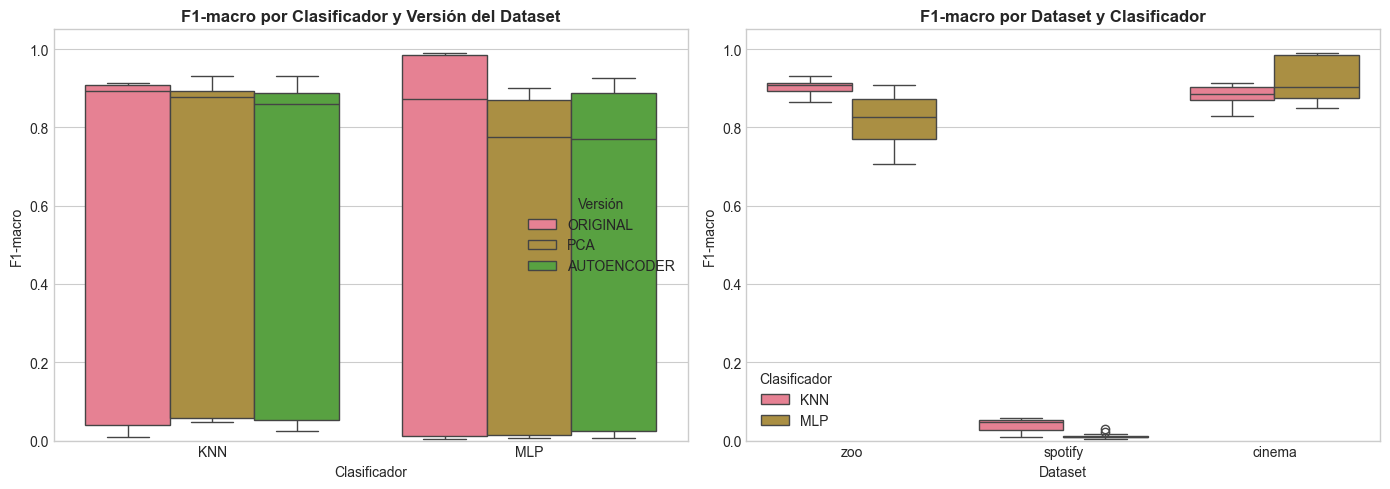

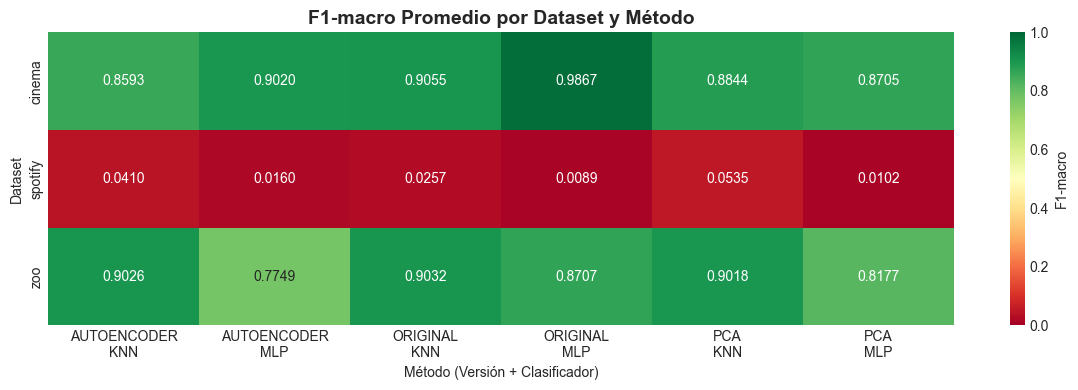

✅ Visualizaciones guardadas: 'comparison_boxplots.png', 'f1_heatmap.png'


In [30]:
# ============================================================================
# 10. VISUALIZACIÓN DE RESULTADOS
# ============================================================================

# Configurar estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Preparar datos para visualización
plot_data = []
for dataset_name in all_results:
    for version in ['original', 'pca', 'autoencoder']:
        if version not in all_results[dataset_name]:
            continue
        for clf in ['knn', 'mlp']:
            if clf not in all_results[dataset_name][version]:
                continue
            res = all_results[dataset_name][version][clf]
            for fold_idx, f1 in enumerate(res['f1_scores'], 1):
                plot_data.append({
                    'Dataset': dataset_name,
                    'Version': version.upper(),
                    'Classifier': clf.upper(),
                    'Fold': fold_idx,
                    'F1-macro': f1,
                    'Method': f"{version.upper()}\n{clf.upper()}"
                })

df_plot = pd.DataFrame(plot_data)

if not df_plot.empty:
    # Figura 1: Comparación por clasificador y versión
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Subplot 1: Box plot por clasificador
    ax1 = axes[0]
    sns.boxplot(data=df_plot, x='Classifier', y='F1-macro', hue='Version', ax=ax1)
    ax1.set_title('F1-macro por Clasificador y Versión del Dataset', fontweight='bold')
    ax1.set_xlabel('Clasificador')
    ax1.set_ylabel('F1-macro')
    ax1.legend(title='Versión')
    ax1.set_ylim(0, 1.05)
    
    # Subplot 2: Box plot por dataset
    ax2 = axes[1]
    sns.boxplot(data=df_plot, x='Dataset', y='F1-macro', hue='Classifier', ax=ax2)
    ax2.set_title('F1-macro por Dataset y Clasificador', fontweight='bold')
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('F1-macro')
    ax2.legend(title='Clasificador')
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig('comparison_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figura 2: Heatmap de F1-macro promedio
    pivot_for_heatmap = df_plot.groupby(['Dataset', 'Method'])['F1-macro'].mean().unstack()
    
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.heatmap(pivot_for_heatmap, annot=True, fmt='.4f', cmap='RdYlGn', 
                ax=ax, vmin=0, vmax=1, cbar_kws={'label': 'F1-macro'})
    ax.set_title('F1-macro Promedio por Dataset y Método', fontweight='bold', fontsize=14)
    ax.set_xlabel('Método (Versión + Clasificador)')
    ax.set_ylabel('Dataset')
    
    plt.tight_layout()
    plt.savefig('f1_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizaciones guardadas: 'comparison_boxplots.png', 'f1_heatmap.png'")
else:
    print("⚠️ No hay datos suficientes para generar visualizaciones")

## 11. Matriz Completa de Comparación Detallada

Matriz exhaustiva mostrando todos los resultados F1 por fold para cada combinación de:
- Dataset
- Versión (Original, PCA, Autoencoder)
- Clasificador (k-NN, MLP)

In [31]:
# ============================================================================
# 11. MATRIZ COMPLETA DE COMPARACIÓN DETALLADA
# ============================================================================

print("=" * 120)
print("MATRIZ COMPLETA DE RESULTADOS F1-MACRO POR FOLD")
print("=" * 120)

# Construir matriz exhaustiva
full_comparison_rows = []

for dataset_name in all_results:
    for fold_idx in range(N_SPLITS):
        row = {
            'Dataset': dataset_name,
            'Fold': f'F{fold_idx + 1}'
        }
        
        for version in ['original', 'pca', 'autoencoder']:
            if version not in all_results[dataset_name]:
                continue
            for clf in ['knn', 'mlp']:
                if clf not in all_results[dataset_name][version]:
                    continue
                col_name = f"{version}_{clf}"
                f1_scores = all_results[dataset_name][version][clf]['f1_scores']
                if fold_idx < len(f1_scores):
                    row[col_name] = f"{f1_scores[fold_idx]:.4f}"
        
        full_comparison_rows.append(row)

df_full = pd.DataFrame(full_comparison_rows)

# Ordenar columnas
base_cols = ['Dataset', 'Fold']
metric_cols = [col for col in df_full.columns if col not in base_cols]
metric_cols_sorted = sorted(metric_cols, key=lambda x: (
    0 if 'original' in x else (1 if 'pca' in x else 2),
    0 if 'knn' in x else 1
))
df_full = df_full[base_cols + metric_cols_sorted]

print("\n📊 Tabla de Resultados F1-macro por Fold:\n")
print(df_full.to_string(index=False))

# Calcular y mostrar estadísticas por método
print("\n" + "=" * 120)
print("📈 ESTADÍSTICAS AGREGADAS POR MÉTODO")
print("=" * 120)

stats_rows = []
for col in metric_cols_sorted:
    values = pd.to_numeric(df_full[col], errors='coerce').dropna()
    if len(values) > 0:
        stats_rows.append({
            'Método': col,
            'Media': f"{values.mean():.4f}",
            'Std': f"{values.std():.4f}",
            'Min': f"{values.min():.4f}",
            'Max': f"{values.max():.4f}",
            'Mediana': f"{values.median():.4f}"
        })

df_stats = pd.DataFrame(stats_rows)
print("\n" + df_stats.to_string(index=False))
print("\n" + "=" * 120)

MATRIZ COMPLETA DE RESULTADOS F1-MACRO POR FOLD

📊 Tabla de Resultados F1-macro por Fold:

Dataset Fold original_knn original_mlp pca_knn pca_mlp autoencoder_knn autoencoder_mlp
    zoo   F1       0.8902       0.8568  0.8915  0.7718          0.8636          0.7473
    zoo   F2       0.9139       0.8727  0.9143  0.7755          0.9139          0.7056
    zoo   F3       0.9097       0.8417  0.8947  0.7619          0.8932          0.7704
    zoo   F4       0.9088       0.9087  0.8766  0.8795          0.9110          0.8249
    zoo   F5       0.8934       0.8738  0.9317  0.8996          0.9317          0.8265
spotify   F1       0.0283       0.0075  0.0513  0.0061          0.0484          0.0100
spotify   F2       0.0102       0.0111  0.0574  0.0156          0.0426          0.0293
spotify   F3       0.0241       0.0087  0.0483  0.0123          0.0235          0.0117
spotify   F4       0.0501       0.0131  0.0589  0.0084          0.0327          0.0075
spotify   F5       0.0157       0.0042 

## 12. Conclusiones y Exportación de Resultados

In [32]:
# ============================================================================
# 12. CONCLUSIONES Y EXPORTACIÓN
# ============================================================================

print("=" * 100)
print("📋 CONCLUSIONES DEL ANÁLISIS")
print("=" * 100)

# Análisis de resultados
print("\n🔍 ANÁLISIS DE RENDIMIENTO:")
print("-" * 60)

# Encontrar mejor método global
best_methods = {}
for dataset_name in all_results:
    best_f1 = -1
    best_method = None
    for version in all_results[dataset_name]:
        for clf in all_results[dataset_name][version]:
            f1 = all_results[dataset_name][version][clf]['mean_f1']
            if f1 > best_f1:
                best_f1 = f1
                best_method = f"{version}_{clf}"
    best_methods[dataset_name] = (best_method, best_f1)
    print(f"   {dataset_name}: Mejor método = {best_method} (F1 = {best_f1:.4f})")

# Análisis de Wilcoxon
print("\n📊 RESUMEN DE TESTS DE WILCOXON:")
print("-" * 60)
significant_count = sum(1 for r in wilcoxon_results if r['significant'] == True)
total_tests = sum(1 for r in wilcoxon_results if r['significant'] is not None)

print(f"   Tests realizados: {len(wilcoxon_results)}")
print(f"   Tests con suficientes datos: {total_tests}")
print(f"   Diferencias significativas: {significant_count}/{total_tests}")

for r in wilcoxon_results:
    if r['significant'] == True:
        print(f"\n   ✅ {r['comparison']}")
        print(f"      p-valor: {r['p_value']:.6f}")
        print(f"      {r['interpretation']}")

# Exportar resultados a CSV
print("\n" + "=" * 100)
print("💾 EXPORTACIÓN DE RESULTADOS")
print("=" * 100)

# Guardar tabla de resultados
df_full.to_csv('results_f1_by_fold.csv', index=False)
print("   ✅ Guardado: results_f1_by_fold.csv")

# Guardar resumen
df_summary.to_csv('results_summary.csv', index=False)
print("   ✅ Guardado: results_summary.csv")

# Guardar resultados de Wilcoxon
df_wilcoxon.to_csv('results_wilcoxon.csv', index=False)
print("   ✅ Guardado: results_wilcoxon.csv")

print("\n" + "=" * 100)
print("🎉 PRÁCTICA 3 COMPLETADA")
print("=" * 100)
print("""
Archivos generados:
├── data/pca/          → Datasets reducidos con PCA
├── data/autoencoder/  → Datasets reducidos con Autoencoder
├── results_f1_by_fold.csv       → F1 por fold para cada método
├── results_summary.csv          → Resumen estadístico
├── results_wilcoxon.csv         → Resultados del test de Wilcoxon
├── comparison_boxplots.png      → Visualización de comparación
└── f1_heatmap.png              → Heatmap de rendimiento

Para añadir más datasets de tus compañeros:
1. Coloca el CSV original en: data/original/
2. Ejecuta el notebook nuevamente
3. Se generarán automáticamente las versiones PCA y Autoencoder
""")

📋 CONCLUSIONES DEL ANÁLISIS

🔍 ANÁLISIS DE RENDIMIENTO:
------------------------------------------------------------
   zoo: Mejor método = original_knn (F1 = 0.9032)
   spotify: Mejor método = pca_knn (F1 = 0.0535)
   cinema: Mejor método = original_mlp (F1 = 0.9867)

📊 RESUMEN DE TESTS DE WILCOXON:
------------------------------------------------------------
   Tests realizados: 5
   Tests con suficientes datos: 5
   Diferencias significativas: 1/5

   ✅ k-NN PCA vs MLP PCA
      p-valor: 0.000183
      Diferencia significativa. pca_knn es significativamente mejor.

💾 EXPORTACIÓN DE RESULTADOS
   ✅ Guardado: results_f1_by_fold.csv
   ✅ Guardado: results_summary.csv
   ✅ Guardado: results_wilcoxon.csv

🎉 PRÁCTICA 3 COMPLETADA

Archivos generados:
├── data/pca/          → Datasets reducidos con PCA
├── data/autoencoder/  → Datasets reducidos con Autoencoder
├── results_f1_by_fold.csv       → F1 por fold para cada método
├── results_summary.csv          → Resumen estadístico
├── results